In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable, grad


In [6]:
class Opt:
    img_size = 64  # Image dimensions
    latent_dim = 100  # Latent vector dimensions
    n_epochs = 40  # Number of epochs
    batch_size = 64  # Batch size
    lr = 0.0002  # Learning rate
    b1 = 0.5  # Beta1 for Adam optimizer
    b2 = 0.999  # Beta2 for Adam optimizer
    n_critic = 5  # Number of critic iterations
    sample_interval = 100  # Interval for saving images
opt = Opt()

# Define image shape
img_shape = (3, opt.img_size, opt.img_size)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 128 * 8 * 8),
            nn.BatchNorm1d(128 * 8 * 8),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
        )

    def forward(self, img):
        return self.model(img)


In [9]:
lambda_gp = 10
 
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

# Configure data loader
transform = transforms.Compose([
    transforms.Resize(opt.img_size),
    transforms.CenterCrop(opt.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataset = datasets.ImageFolder(root='D:\\Monotype_project\\cat1\\cat', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [10]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    batch_size = real_samples.size(0)
    alpha = Tensor(np.random.random((batch_size, 1, 1, 1)))  # Correct shape: (batch_size, 1, 1, 1)
    
    # Interpolate between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # Get discriminator output for interpolates
    d_interpolates = D(interpolates)
    
    # Create labels for gradient penalty calculation
    fake = Variable(Tensor(batch_size, 1).fill_(1.0), requires_grad=False)
    
    # Compute gradients with respect to interpolates
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [11]:
# Initialize lists to store losses
g_losses = []
d_losses = []

# Training
batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        fake_imgs = generator(z)

        real_validity = discriminator(real_imgs)
        fake_validity = discriminator(fake_imgs.detach())
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        # Store Discriminator loss
        d_losses.append(d_loss.item())

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:
            optimizer_G.zero_grad()

            fake_imgs = generator(z)
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            # Store Generator loss
            g_losses.append(g_loss.item())

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )


            batches_done += opt.n_critic
        save_image(fake_imgs.data, f'images1/fake_images_epoch_{epoch+1}.png', normalize=True)

[Epoch 0/40] [Batch 0/27] [D loss: 254.419418] [G loss: -0.212364]
[Epoch 0/40] [Batch 5/27] [D loss: 43.381523] [G loss: -0.216682]
[Epoch 0/40] [Batch 10/27] [D loss: 12.936790] [G loss: -0.228684]
[Epoch 0/40] [Batch 15/27] [D loss: 3.656183] [G loss: -0.225624]
[Epoch 0/40] [Batch 20/27] [D loss: 1.225814] [G loss: -0.223394]
[Epoch 0/40] [Batch 25/27] [D loss: 0.751293] [G loss: -0.228175]
[Epoch 1/40] [Batch 0/27] [D loss: 0.816999] [G loss: -0.252984]
[Epoch 1/40] [Batch 5/27] [D loss: 0.225553] [G loss: -0.265290]
[Epoch 1/40] [Batch 10/27] [D loss: 0.573571] [G loss: -0.265914]
[Epoch 1/40] [Batch 15/27] [D loss: 0.266043] [G loss: -0.272925]
[Epoch 1/40] [Batch 20/27] [D loss: 0.231930] [G loss: -0.269910]
[Epoch 1/40] [Batch 25/27] [D loss: 0.328819] [G loss: -0.262043]
[Epoch 2/40] [Batch 0/27] [D loss: 0.325584] [G loss: -0.281127]
[Epoch 2/40] [Batch 5/27] [D loss: 0.294725] [G loss: -0.265568]
[Epoch 2/40] [Batch 10/27] [D loss: 0.197853] [G loss: -0.243684]
[Epoch 2/40]

[Epoch 20/40] [Batch 20/27] [D loss: -0.056618] [G loss: -0.029042]
[Epoch 20/40] [Batch 25/27] [D loss: -0.038745] [G loss: -0.023832]
[Epoch 21/40] [Batch 0/27] [D loss: -0.014799] [G loss: -0.039310]
[Epoch 21/40] [Batch 5/27] [D loss: -0.051334] [G loss: -0.046424]
[Epoch 21/40] [Batch 10/27] [D loss: -0.077389] [G loss: -0.040305]
[Epoch 21/40] [Batch 15/27] [D loss: -0.042203] [G loss: -0.047645]
[Epoch 21/40] [Batch 20/27] [D loss: -0.057056] [G loss: -0.051532]
[Epoch 21/40] [Batch 25/27] [D loss: -0.054996] [G loss: -0.055289]
[Epoch 22/40] [Batch 0/27] [D loss: -0.038390] [G loss: -0.064214]
[Epoch 22/40] [Batch 5/27] [D loss: -0.063942] [G loss: -0.064011]
[Epoch 22/40] [Batch 10/27] [D loss: -0.045897] [G loss: -0.069403]
[Epoch 22/40] [Batch 15/27] [D loss: -0.067881] [G loss: -0.060416]
[Epoch 22/40] [Batch 20/27] [D loss: -0.057252] [G loss: -0.066961]
[Epoch 22/40] [Batch 25/27] [D loss: -0.042588] [G loss: -0.065121]
[Epoch 23/40] [Batch 0/27] [D loss: -0.050974] [G lo

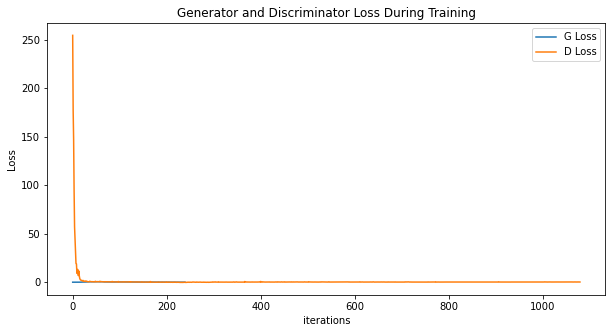

In [12]:
# Save loss data
np.save('g_losses.npy', g_losses)
np.save('d_losses.npy', d_losses)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G Loss")
plt.plot(d_losses, label="D Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
